In [40]:
#in case of running this in colab 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#not included by default
!pip install rasterio arr

In [42]:
#imports 

from PIL import Image 
import gdal
import rasterio 
import pandas as pd
import numpy as np
from matplotlib import image as im
from matplotlib import pyplot as plt
from affine import Affine

In [43]:
filepath ='/content/drive/MyDrive/Honors/MapBiomas/C5-2019.tif'
#path to the MapBiomas land cover file from collection 5 in 2019 - here renamed C5-2019.tif

with rasterio.open(filepath) as src:
    print(src.profile)
    #some some basic info

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 113487, 'height': 81381, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -73.98327050645874,
       0.0, -0.00026949458523585647, 5.269697119701937), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


For interpretation of these keys visit: https://rasterio.readthedocs.io/en/latest/quickstart.html

In [44]:
#another way of retrieving similar info
src.meta

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 81381,
 'nodata': None,
 'transform': Affine(0.00026949458523585647, 0.0, -73.98327050645874,
       0.0, -0.00026949458523585647, 5.269697119701937),
 'width': 113487}

In [45]:
print(src.bounds) #how much are edges of the image away from the reference coordinate point
print(src.crs) #coordinate system
src.indexes

BoundingBox(left=-73.98327050645874, bottom=-16.662041721377296, right=-43.39913851179709, top=5.269697119701937)
EPSG:4326


(1,)

Text(0, 0.5, 'Row #')

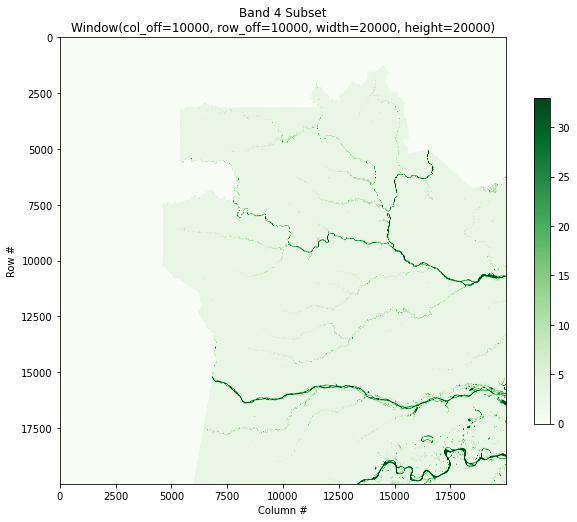

In [46]:
#visualize part of the image

window = rasterio.windows.Window(10000, 10000, 20000, 20000)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(10,12))
plt.imshow(subset,  cmap='Greens')
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

#Cropping the file


In [ ]:
#this function could be used to generate the window from which we crop the file 
def window_from_extent(xmin, xmax, ymin, ymax, aff):
    col_start, row_start = ~aff * (xmin, ymax)
    col_stop, row_stop = ~aff * (xmax, ymin)
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

src = rasterio.open(filepath)
data = np.empty([140431,256,256]) 
#(256 is the size of the images we want in pixels, 140431 is how many pictures)
pic_index = 0

for i in range(317): #height of the whole file / 256
  for j in range(443): #width of the whole file / 256
    aff = src.meta['transform']
    meta = src.meta.copy()
    #generate a window with starting and ending points of each picture
    window = window_from_extent(int(i*256), int((i*256)+256), int(j*256), int((j*256)+256), aff)
    #read croped array
    step = src.read(1, window=window)
    data[pic_index] = step
    #update dataset metadata (if you need it)
    meta.update(height = window[0][1] - window[0][0],
                width = window[1][1] - window[1][0],
                affine = src.window_transform(window))
    meta.pop('transform', None)
    pic_index += 1